<a href="https://colab.research.google.com/github/alifele/EEG-computation/blob/master/Final_Version.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Important libraries

In [54]:
!pip install mat4py
import numpy as np
import matplotlib.pyplot as plt
import mat4py as mt
import os
from IPython.display import Image
from IPython.core.display import HTML 
from itertools import combinations
from numpy.fft import fft
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier,export_graphviz
from sklearn.metrics import confusion_matrix, classification_report

# Importing Data from GitHub Page

In [55]:
!git clone https://github.com/alifele/EEG-computation.git
%cd EEG-computation

Cloning into 'EEG-computation'...
remote: Enumerating objects: 401, done.
remote: Counting objects: 100% (401/401), done.
remote: Compressing objects: 100% (397/397), done.
remote: Total 401 (delta 27), reused 351 (delta 2), pack-reused 0
Receiving objects: 100% (401/401), 580.13 MiB | 42.14 MiB/s, done.
Resolving deltas: 100% (27/27), done.
Checking out files: 100% (342/342), done.
/content/EEG-computation/EEG-computation


In [0]:
disorder_dic = []
directory = os.fsencode('EEG Data/disorder')
for file in os.listdir(directory):
    filename = os.fsdecode(file)
    disorder_dic.append(np.array(mt.loadmat('EEG Data/disorder/{}'.format(filename))[filename.split('.')[0]]))
    
channels_disorder = [ [] for i in range(len(disorder_dic))]  #channels[person][channel] it will be a numpy array
j=0;
for person in channels_disorder:
    for i in range(19):
        person.append(disorder_dic[j][:,i])
    j+=1
        
normal_dic = []
directory = os.fsencode('EEG Data/normal')
for file in os.listdir(directory):
    filename = os.fsdecode(file)
    normal_dic.append(np.array(mt.loadmat('EEG Data/normal/{}'.format(filename))[filename.split('.')[0]]))
    
channels_normal = [ [] for i in range(len(normal_dic))]  #channels[person][channel] it will be a numpy array
j=0;
for person in channels_normal:
    for i in range(19):
        person.append(normal_dic[j][:,i])
    j+=1    
        
data = {"N":channels_normal,
      "D":channels_disorder}



(-4, 256.0)

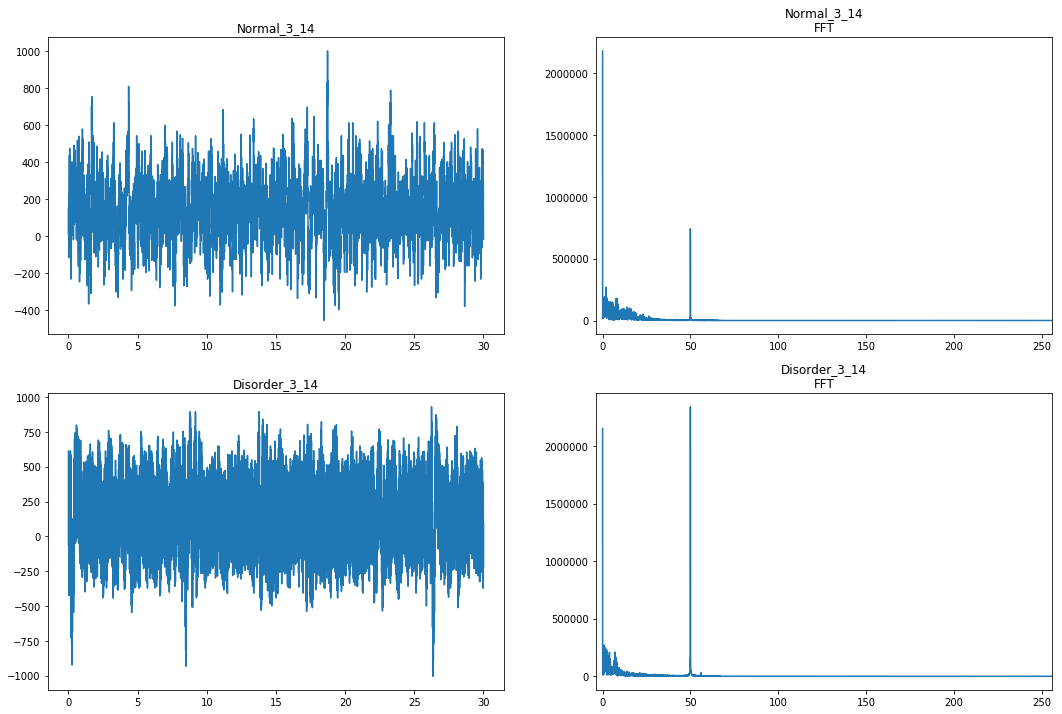

In [57]:
t = np.linspace(0,30,512*30)
f = np.linspace(0,512,512*30)
fig = plt.figure( 'Example Plot', figsize=(18,12))
ax = fig.add_subplot(2,2,1, title = 'Normal_3_14')
ax.plot(t,data["N"][18][16])
ax = fig.add_subplot(2,2,2, title = 'Normal_3_14\nFFT')
ax.plot(f,abs(np.fft.fft(data["N"][18][16])))
ax.set_xlim([-4,512/2])
ax = fig.add_subplot(2,2,3, title = 'Disorder_3_14')
ax.plot(t,data["N"][54][16])
ax = fig.add_subplot(2,2,4, title = 'Disorder_3_14\nFFT')
ax.plot(f,abs(np.fft.fft(data['N'][54][16])))
ax.set_xlim([-4,512/2])


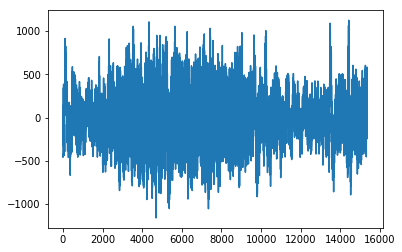

In [58]:
#plt.plot(abs(np.fft.fft(data["N"][18][16]))-abs(np.fft.fft(data["N"][5][16])))
plt.plot(data['N'][8][16] - data['N'][54][16])

## Generating New Data

In [0]:
def New_Data_Generator_N():
    number_of_samples =  50
    randlist = (132 * np.random.random(number_of_samples)).astype(int)
    new_patients = list(data['N'][i] for i in randlist)
    
    index = [ i for i in range(number_of_samples)]
    comb = list( combinations(index, 2))
    new_data = [[] for i in range(len(comb))]
    person = 0
    for x,y in comb:
        for chan in range(19):
            new_data[person].append((new_patients[x][chan] + new_patients[y][chan] )/2)
        data['N'].append(new_data[person])
        person += 1

    
def New_Data_Generator_D():
    number_of_samples = 50
    randlist = (132 * np.random.random(number_of_samples)).astype(int)
    new_patients = list(data['D'][i] for i in randlist)
    
    index = [ i for i in range(number_of_samples)]
    comb = list( combinations(index, 2))
    new_data = [[] for i in range(len(comb))]
    person = 0
    for x,y in comb:
        for chan in range(19):
            new_data[person].append((new_patients[x][chan] + new_patients[y][chan] )/2)
        data['D'].append(new_data[person])
        person += 1

In [0]:
New_Data_Generator_N()
New_Data_Generator_D()

In [61]:
n_D , n_N = len(data['D']), len(data['N'])
n_D, n_N

(1421, 1357)

# Making Fourier Transform DataSet and Deleting Noise

In [62]:


index = np.arange(0,512*30)
f = np.linspace(0,512,512*30)
f_max = f[len(f[f<120])]
ind_min = 2
ind_max = list(index[f==f_max])[0]
f_min = f[ind_min]

print(f_min, f_max, ind_min, ind_max)


sam_FT = np.abs(fft(data['D'][50][7]))

# The 50 Htz noise elimination information

f_45 = f>45
f_55 = f<55
f_bar = f<45

for i in range(f.shape[0]):
  f_bar[i] = f_45[i] and f_55[i]
  
  
noise = f[sam_FT == np.max(sam_FT[f_bar])][0]
noise_index = list(index[f==noise])[0] # in range 0, 512*30
del_domain = 40
del_range = [noise_index + i for i in range(-del_domain,del_domain)]
print(noise, noise_index)



0.06667100722703301 120.00781300865941 2 3600
50.03659092388827 1501


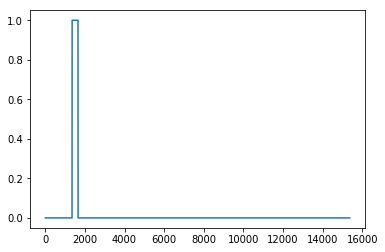

In [63]:
plt.plot(f_bar)

## Noise Delete

In [0]:
f = np.linspace(0,512,512*30)[ind_min:ind_max]

In [0]:
normal = [[np.zeros(f.shape[0]) for k in range(19)] for i in range(n_N)]
disorder = [[np.zeros(f.shape[0]) for k in range(19)] for i in range(n_D)]


FT = {'D':disorder,
     'N':normal}

from numpy.fft import fft

for d in range(n_D):
    for i in range(19):
        
        FT['D'][d][i] = np.abs(fft(data['D'][d][i]))[ind_min:ind_max]
        FT['D'][d][i][noise_index-del_domain  - ind_min: noise_index+del_domain - ind_min] = np.average(FT['D'][d][i][noise_index-del_domain  - ind_min - 120: noise_index+del_domain - ind_min-120])
        FT['D'][d][i][2*noise_index-del_domain - ind_min: 2*noise_index+del_domain - ind_min] = np.average(FT['D'][d][i][2*noise_index-del_domain - ind_min - 120: 2*noise_index+del_domain - ind_min-120])
    
for n in range(n_N):
    for i in range(19):
        FT['N'][n][i] = np.abs(fft(data['N'][n][i]))[ind_min:ind_max]
        FT['N'][n][i][noise_index-del_domain - ind_min: noise_index+del_domain -ind_min] = np.average(FT['N'][n][i][noise_index-del_domain - ind_min-120: noise_index+del_domain -ind_min-120])
        FT['N'][n][i][2*noise_index-del_domain - ind_min: 2*noise_index+del_domain - ind_min] = np.average( FT['N'][n][i][2*noise_index-del_domain - ind_min-120 : 2*noise_index+del_domain - ind_min-120])
        

    FT['N'] = np.array(FT['N'])
    FT['D'] = np.array(FT['D'])


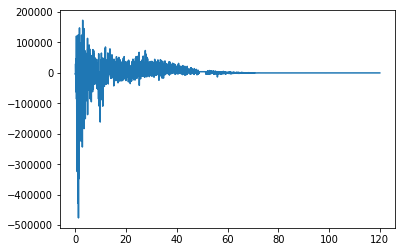

In [66]:
plt.plot(f, FT['D'][56][8] - FT['D'][105][8])
#plt.plot(f, FT['D'][95][8])

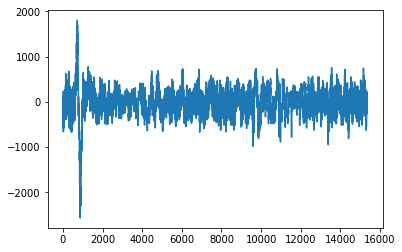

In [67]:
plt.plot(data['D'][3][4] - data['D'][50][4])

In [0]:
%reset_selective -f "^data$"

## Data Shaper and Scale

In [0]:
FT_matrix_N = FT['N']
FT_matrix_D = FT['D']

temp_D = FT_matrix_D.reshape((FT_matrix_D.shape[0],FT_matrix_D.shape[2],FT_matrix_D.shape[1]))
temp_N = FT_matrix_N.reshape((FT_matrix_N.shape[0],FT_matrix_N.shape[2],FT_matrix_N.shape[1]))
#or d in range(FT_matrix.shape[0]):
scaler = StandardScaler()

In [0]:
%reset_selective -f "^FT$"

In [0]:
for n in range(FT_matrix_N.shape[0]):
  temp_N[n]= scaler.fit_transform(FT_matrix_N[n].T)
  
for d in range(FT_matrix_D.shape[0]):
  temp_D[d]= scaler.fit_transform(FT_matrix_D[d].T)

In [0]:
for n in range(FT_matrix_N.shape[0]):
  FT_matrix_N[n]= scaler.fit_transform(temp_N[n].T)
  
for d in range(FT_matrix_D.shape[0]):
  FT_matrix_D[d]= scaler.fit_transform(temp_D[d].T)



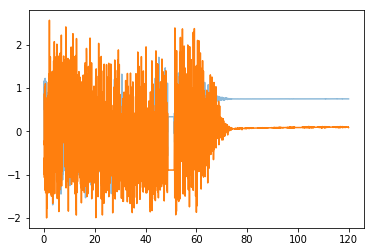

In [73]:
plt.plot(f,FT_matrix_D[16,5], alpha=0.5)
#plt.plot(f,FT_matrix_D[9,8])
plt.plot(f,FT_matrix_D[25,5])

In [0]:
# normal is 1 and disorder is 0
Data = np.vstack((FT_matrix_N, FT_matrix_D))
target = np.hstack((np.ones(FT_matrix_N.shape[0]), np.zeros(FT_matrix_D.shape[0])))

In [0]:
X, y = shuffle(Data, target)

In [76]:
X.shape, y.shape

((2778, 19, 3598), (2778,))

In [0]:
%reset_selective -f "^FT_matrix_D$"
%reset_selective -f "^FT_matrix_N$"
%reset_selective -f "^temp_D$"
%reset_selective -f "^temp_N$"
%reset_selective -f "^Data$"
%reset_selective -f "^target$"


#PCA

In [0]:
X = X.reshape(X.shape[0],-1)
X_train, X_test, y_train, y_test = train_test_split(X,y)

In [0]:
%reset_selective -f "^X$"
%reset_selective -f "^y$"

the scree plot of the features is :


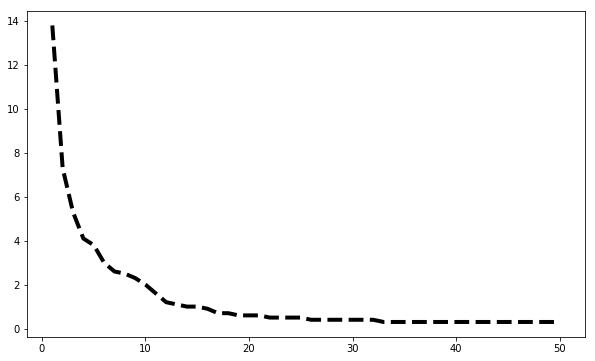

In [80]:


n=50
pca = PCA(n)
pca.fit(X_train)
data = pca.transform(X_train)
per_var = np.round(pca.explained_variance_ratio_ * 100, decimals=1)
#labels = ["PC" + str(i) for i in range (1,len(per_var)+1)]
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(1,1,1)
print('the scree plot of the features is :')
#ax.bar(x=range(1,len(per_var)+1),height=per_var,tick_label=labels)
ax.plot(range(1,len(per_var)+1),per_var,'k--',linewidth=4,)



In [0]:
pca = PCA(n_components = 20)


In [82]:
pca.fit(X_train)
X_train_pca = pca.transform(X_train)
X_train_pca.shape

(2083, 20)

In [83]:
X_test_pca = pca.transform(X_test)
X_test_pca.shape

(695, 20)

#Decision Tree

In [84]:
model = DecisionTreeClassifier(max_depth=10)
model.fit(X_train_pca,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [85]:
Y_predict = model.predict(X_test_pca)
cnfmatrix = confusion_matrix(y_test,Y_predict)
print(cnfmatrix)

[[298  34]
 [ 31 332]]


In [86]:
clf_report = classification_report(y_test, Y_predict)
print(clf_report)

              precision    recall  f1-score   support

         0.0       0.91      0.90      0.90       332
         1.0       0.91      0.91      0.91       363

    accuracy                           0.91       695
   macro avg       0.91      0.91      0.91       695
weighted avg       0.91      0.91      0.91       695



In [87]:
feature_names = ['PCA{}'.format(i) for i in range(1,X_train_pca.shape[1]+1)]
feature_names

['PCA1',
 'PCA2',
 'PCA3',
 'PCA4',
 'PCA5',
 'PCA6',
 'PCA7',
 'PCA8',
 'PCA9',
 'PCA10',
 'PCA11',
 'PCA12',
 'PCA13',
 'PCA14',
 'PCA15',
 'PCA16',
 'PCA17',
 'PCA18',
 'PCA19',
 'PCA20']

In [0]:
target_names = ['disorder', 'normal']

In [0]:
export_graphviz(model,
               out_file='image.dot',
               feature_names=feature_names,
               class_names = target_names,
               rounded = True,
               filled=True)

In [0]:
! dot -Tpng image.dot -o image.png

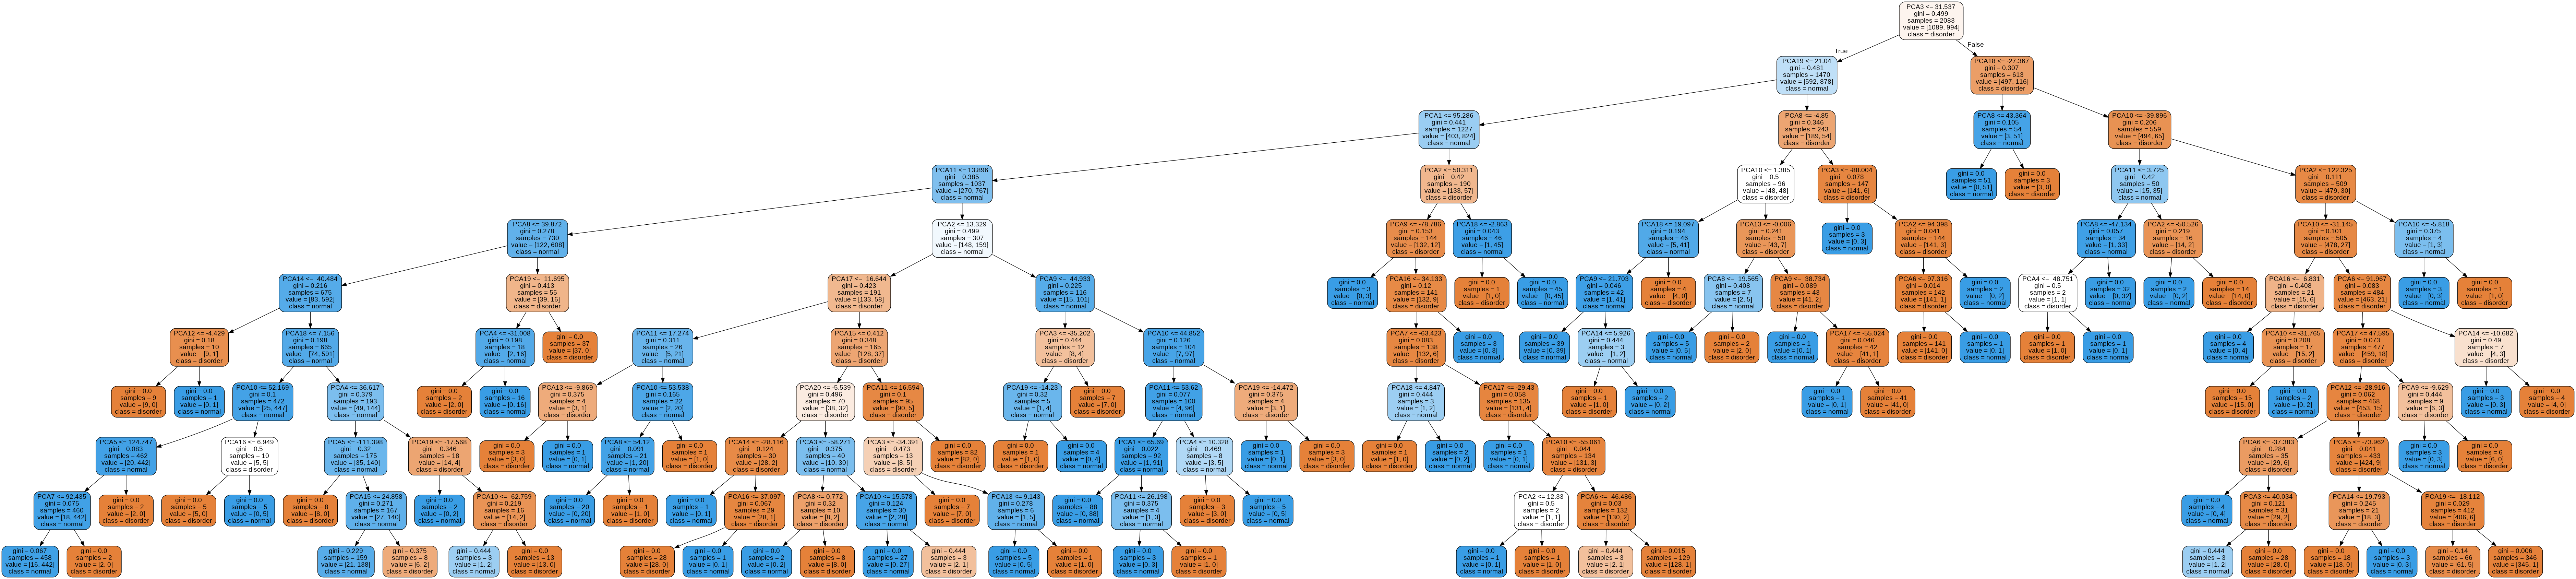

In [93]:
from IPython.display import Image
Image('image.png')